In [111]:
# pip install folium matplotlib mapclassify contextily imageio

In [112]:
import geopandas as gpd
lakes = gpd.read_file('berlin_small_lakes/berlin_small_lakes.shp')
lakes = lakes.to_crs("EPSG:4326")

# Calculate total bounds and dilate
pad = 0.5  # degrees of lat/lon to expand the box
minx, miny, maxx, maxy = lakes.total_bounds
bbox = (minx - pad, miny - pad, maxx + pad, maxy + pad)  # expanded bbox
bounding_box = box(*bbox)

# Make a geopandas data frame so we can plot the bounding box, copy the crs over
bounding_box_df = gpd.GeoDataFrame([[bounding_box]] ,columns=['geometry'], crs = lake.crs)


m = lakes.explore(
    column="GEW_NAME",  # make choropleth based on "BoroName" column
    tooltip="GEW_NAME",  # show "BoroName" value in tooltip (on hover)
    popup=True,  # show all values in popup (on click)
    # tiles="CartoDB positron",  # use "CartoDB positron" tiles
    cmap="Set1",  # use "Set1" matplotlib colormap
    style_kwds=dict(color="black"),  # use black outline
    legend = False,
)

bounding_box_df.explore(m=m)
m

In [113]:
import yaml
from pathlib import Path
from zipfile import ZipFile
import xarray as xr
from cartopy import crs as ccrs, feature as cfeat
from matplotlib import pyplot as plt
import cdsapi
import contextily as cx
import imageio.v2 as imageio  # using v2 interface for compatibility


with open(Path("~/.cdsapirc_xds_dev").expanduser(), "r") as f:
    credentials = yaml.safe_load(f)

In [114]:
dataset = "ad4gd-air-quality"
request = {
    "variable": ["particulate_matter_d_2_5_µm"],
    "month": ["10"],
    "day": ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"],
    "area": [bbox[1], bbox[0], bbox[3], bbox[2]],
    # "area": [53.23, -0.64, 43.83, 12.51],
}

client = cdsapi.Client(**credentials)
filename = client.retrieve(dataset, request).download()

2025-04-11 10:11:14,884 INFO Request ID is a436a574-2013-418f-8e2f-d9b939ae6094
2025-04-11 10:11:15,063 INFO status has been updated to accepted
2025-04-11 10:11:17,193 INFO status has been updated to running
2025-04-11 10:11:37,441 INFO status has been updated to successful


In [115]:
def plot(ds, outfile=None):
    mods = ds.mean('time')
    data_var = list(mods.data_vars)[0]
    data = mods[data_var]
     
    fig, ax = plt.subplots(figsize=(8, 7), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_aspect('auto')
    cm = ax.pcolormesh(mods.lon, mods.lat, data, vmin=0, vmax=20,
                       cmap='turbo', transform=ccrs.PlateCarree(), alpha = 0.5)
    fig.colorbar(cm, ax=ax, label=r'PM2.5 Concentration ($\mu$g/m$^3$)')
    ax.coastlines('10m', lw=0.5)
    cx.add_basemap(ax, crs=lakes.crs)
    ax.add_feature(cfeat.BORDERS, lw=0.5)
    ax.set_title('IoT+CAMS PM2.5 Concentration', fontweight='bold', loc='left')
    fig.tight_layout()
    if outfile is not None:
        plt.savefig(outfile)
        plt.close(fig)  # prevents auto-display in notebooks

with ZipFile(filename) as myzip:
    for file_info in myzip.infolist():
        with myzip.open(file_info) as f:
            ds = xr.open_dataset(f, engine="h5netcdf")
            plot(ds)
        break

ds

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 24, lat: 127, lon: 162)
Coordinates:
  * lat      (lat) float64 1kB 51.88 51.89 51.9 51.91 ... 53.12 53.13 53.14
  * lon      (lon) float64 1kB 12.6 12.61 12.62 12.63 ... 14.18 14.19 14.2 14.21
  * time     (time) datetime64[ns] 192B 2024-10-01 ... 2024-10-01T23:00:00
Data variables:
    pm2p5    (time, lat, lon) float32 2MB 6.572 6.614 6.656 ... 9.987 9.921
Attributes:
    title:        PM2.5 mass concentration
    Conventions:  CF-1.8
    institution:  AD4GD
    source:       IoT sensor network
    history:      Created 2025-04-09 13:06:07.088825
    summary:      A high resolution dataset for particulate matter (PM2.5 and...
    license:      The dataset is distributed under the Licence to Use Coperni...
    references:   https://doi.org/10.5281/zenodo.10839023

In [116]:
# from zipfile import ZipFile
# import xarray as xr
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeat
# import imageio.v2 as imageio  # using v2 interface for compatibility
# import tempfile
# import os

# Temporary storage for images
image_files = []

with ZipFile(filename) as myzip:
    for i, file_info in enumerate(myzip.infolist()):
        with myzip.open(file_info) as f:
            ds = xr.open_dataset(f, engine="h5netcdf")
            # Save plot to temporary file
            tmp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
            plot(ds, tmp_file.name)
            image_files.append(tmp_file.name)

print(f"{len(image_files)} frames")
# Create a GIF from the images
imageio.mimsave("pm25_animation.gif", [imageio.imread(f) for f in image_files], fps=2, loop=0)

# Clean up temporary files
for f in image_files:
    os.remove(f)

print("GIF saved as 'pm25_animation.gif'");

10 frames
GIF saved as 'pm25_animation.gif'


<img src="pm25_animation.gif" width="750" align="center">

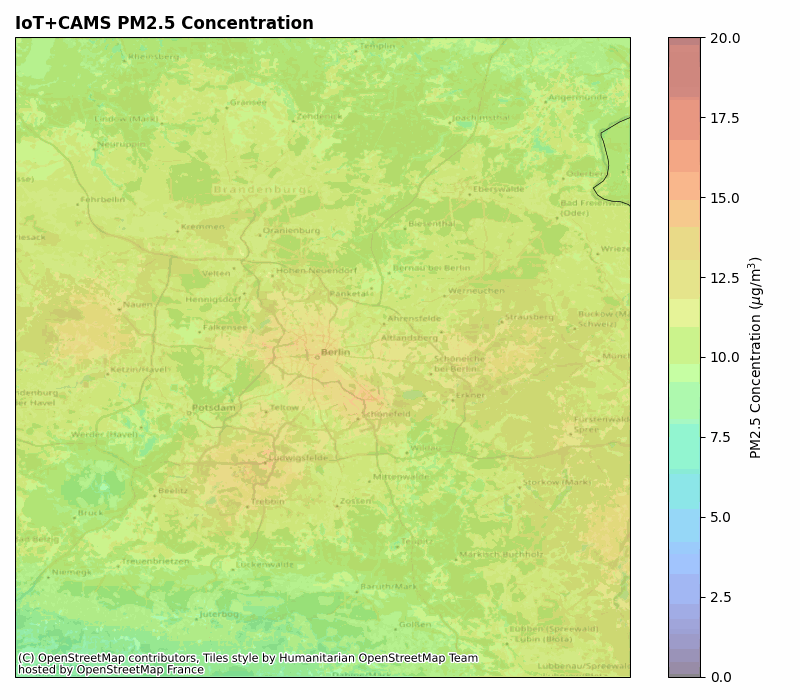

In [117]:
from IPython.display import display, Image

display(Image(data=open('pm25_animation.gif','rb').read(), format='gif'))